<font size="5">Estimating implied time scales with bootstrapping</font>

In [3]:
from msmbuilder.msm import MarkovStateModel
from multiprocessing import Pool
from itertools import repeat
import pandas as pd
import numpy as np
import os

os.makedirs('./microstate_MSM_and_PCCA',exist_ok=True)

def at_lagtime(lt,choice):
    """
    Calculate the implied timescales from a series of MSM lag time, based on the choice of MD trajectories

    Parameters
    ----------
    lt: list
        A list consists of MSM lag time

    choice: list
        A list consists of choice of MD trajectories

    Return
    ----------
    df: pandas dataframe
        a pandas dataframe containing the implied timescales at different lag time

    """
    clustering=np.load("./APLoD_clustering/no_of_features/1000/clustering_assignments.npy")
    clustering_sequence=[]
    for i in choice:
        clustering_sequence.append(clustering[i])
    df=pd.DataFrame()
    for o,n in enumerate(lt):
        msm = MarkovStateModel(lag_time=n, n_timescales=10, reversible_type="transpose", verbose=False,ergodic_cutoff="off")
        msm.fit(clustering_sequence)
        timescales={}
        timescales['lag_time']=[]
        timescales['lag_time'].append(n)
        for n in range(msm.n_timescales):
            timescales['timescale_{}'.format(n)] =[]
        for n in range(msm.n_timescales):
            timescales['timescale_{}'.format(n)].append(msm.timescales_[n])
        lt_df  = pd.DataFrame(timescales, columns=timescales.keys())
        df = pd.concat([df, lt_df],ignore_index=True)
    return df

def its_bootstrap(lt,bootstrap_no,msm_dir='./microstate_MSM_and_PCCA/'):
    """
   A Wrapper for doing boostrapping on the implied time scales

    Parameters
    ----------
    lt: list
        A list consists of MSM lag time

    bootstrap_no: int
        Number of subsampling to be done

    msm_dir: str
        Directory for saving the output

    Return
    ----------
    df: pandas dataframe
        a pandas dataframe containing the implied timescales at different lag time after bootstraping

    """
    bootstrap=[]
    traj=np.arange(bootstrap_no)
    os.makedirs("{}choice/".format(msm_dir),exist_ok=True)
    pool = Pool()
    if __name__ == '__main__':
        while True:
            try:
                for i in range(bootstrap_no):
                    choice=np.random.choice(traj, bootstrap_no, replace=True).tolist()
                    bootstrap.append(choice)
                    np.savetxt("{}choice/choice{}.txt".format(msm_dir,i),choice,fmt='%i')
                dfs=pool.starmap(at_lagtime, zip(repeat(lt),bootstrap))
            except ValueError:
                print('Rerunning due to NaN in transition counts')
                pass
            else:
                break
        data = pd.concat(dfs, ignore_index=True)
        return data

msm_dir='./microstate_MSM_and_PCCA/'

lagtimes=[1,5]
for i in range(100,2801,100) :
    lagtimes.append(i)

no_of_traj=84

#You may want to rerun this cell if you encountered a ValueError (or an infiinite loop)
data=its_bootstrap(lagtimes,no_of_traj)
data.to_csv(msm_dir+'timescales.txt',index=False,sep="\t",float_format='%g')
data.to_pickle(msm_dir+'timescales.pickl')

<font size="5">Plotting the implied time scales against lag time</font>

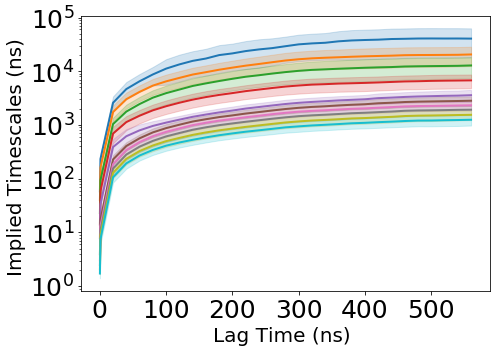

In [3]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
msm_dir='./microstate_MSM_and_PCCA/'


def load_its(data,n_timescales,lagtimes):
    """
    Caculating the mean and the standard deviation for implied time scales 
    Parameters
    ----------
    data: pandas dataframe
        A list consists of MSM lag time
        
    n_timescales: int
        Number of implied timescales caluclated 
    
    lagtimes: list
        A list containing MSM lag time for plotting the implied timescales
        
    Return
    ----------
    av_dict: dict
        a dictionary containing the mean implied timescales
        
    error_dict: dict
        a dictionary containing the standard deviation of implied timescales
    
    """
    data=pd.read_pickle(data)
    dict_={}
    av_dict={}
    error_dict={}
    for i in range(n_timescales):
        dict_[i]=[]
        av_dict[i]=[]
        error_dict[i]=[]

    for m,i in enumerate(lagtimes):
        temp=data.query("lag_time == '{}'".format(i))
        for n in range(10):
            dict_[n].append(temp["timescale_{}".format(n)].values.tolist())
            av_dict[n].append(np.average(dict_[n][m]))
            error_dict[n].append(np.std(dict_[n][m]))
    return av_dict, error_dict


def plot_timescales(ax,n_timescales,lagtime,av_dict,error_dict):
    """
    Plotting the mean and standard deviation for implied time scales 
    Parameters
    ----------
    ax: matplotlib.axis Class object
        The matplotlib.axis to plot 
    
    n_timescales: int
        Number of implied timescales caluclated 
    
    lagtimes: list
        A list containing MSM lag time for plotting the implied timescales
        
    av_dict: dict
        a dictionary containing the mean implied timescales
        
    error_dict: dict
        a dictionary containing the standard deviation of implied timescales
    
    """
    colors=['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple',
        'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
    for i,color in zip(range(n_timescales),colors):
        ax.plot(np.array(lagtimes)*0.2,
                   np.array(av_dict[i])*0.2,
                   markersize=3,linewidth=2,linestyle='solid', c=color,
                   )
        ax.fill_between(np.array(lagtimes)*0.2, 
                        (np.array(av_dict[i])-np.array(error_dict[i]))*0.2,
                        (np.array(av_dict[i])+np.array(error_dict[i]))*0.2,
                        color=color,alpha=0.2)
    xmin, xmax = ax.get_xlim()
    xx = np.linspace(xmin, xmax)
    ax.set_xlabel('Lag Time (ns) ', fontsize=20)
    ax.set_ylabel('Implied Timescales (ns) ', fontsize=20)
    ax.set_yscale('log')
    plt.xticks(size=25)
    plt.yticks(size=25)
    plt.tight_layout()
    plt.savefig(msm_dir+'its_plot.png',transparent=True)

msm_dir='./microstate_MSM_and_PCCA/'

lagtimes=[1,5]
for i in range(100,2801,100) :
    lagtimes.append(i)
    
    
#Plotting implied timescales against lag time
fig, ax = plt.subplots(figsize=(7,5))
av_dict, error_dict=load_its(msm_dir+'timescales.pickl',n_timescales=10,lagtimes=lagtimes)
plot_timescales(ax,10,lagtimes,av_dict,error_dict)




<font size="5">Lumping with PCCA+</font>

In [5]:
#Performing Lumping with PCCA+
from msmbuilder.lumping import PCCAPlus
from msmbuilder.msm import MarkovStateModel
import numpy as np
from msmbuilder.io import save_generic
import os

#Load clustering assignment
msm_dir='./microstate_MSM_and_PCCA/'
qmsm_dir='./qMSM/'
assignments=np.load("./APLoD_clustering/no_of_features/1000/clustering_assignments.npy")

#Generating the microstate TPM at lag time=380ns for lumping
msm=MarkovStateModel(verbose=True, lag_time=1900, reversible_type='transpose', ergodic_cutoff='off')
msm_assignments=msm.fit_transform(assignments)
save_generic(msm,"{}msm.pickl".format(msm_dir))

np.savetxt(msm_dir+"microstate_TCM_LT380ns.txt",msm.countsmat_)
np.savetxt(msm_dir+"microstate_TPM_LT380ns.txt", msm.transmat_)
np.savetxt(msm_dir+"microstate_Population_LT380ns.txt", msm.populations_)

#lumping
pcca = PCCAPlus.from_msm(msm, n_macrostates=4)
lumped_trajs = pcca.fit_transform(assignments)
lumped_trajs=np.concatenate(lumped_trajs)
save_generic(pcca,"{}pcca.pickl".format(msm_dir))
np.save("{}lumping_assignment.npy".format(qmsm_dir),lumped_trajs)


Optimization terminated successfully.
         Current function value: -3.863031
         Iterations: 18
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -3.855247
         Iterations: 9
         Function evaluations: 98


<font size="5">Plotting Free Energy Landscape along tlCA subspace</font>

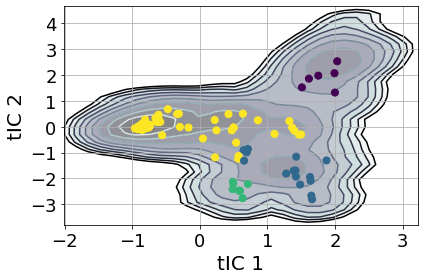

In [6]:
import msmexplorer as msme
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def free_energy_plot_macrostate(no_of_traj,tica_dir,msm_dir,aplod_dir):
    """
    Caculating the mean and the standard deviation for implied time scales 
    Parameters
    ----------
    no_of_traj: int
        The number of files to load from tlCA
        
    tica_dir: str
        Directories containing the tlCA coordinates
    
    msm_dir: str
        Directories for saving the output
        
    aplod_dir: str
        Directories containing the APLoD clustering assignment 
    
    """
    tica_trajs=[]
    for i in range(no_of_traj):
        temp=np.load(tica_dir+"{0}.npy".format(i))[:,0:2]
        tica_trajs.append(temp)
    tica_traj=np.array(tica_trajs)
    trajs=np.concatenate(tica_traj)

    pcca=pd.read_pickle(msm_dir+'pcca.pickl')
    msm=pd.read_pickle(msm_dir+'msm.pickl')
    aplod_centers=np.load(aplod_dir+'clustering_centers.npy')
    aplod_centers_coord=[trajs[i] for i in aplod_centers]
    aplod_centers_coord=np.array(aplod_centers_coord)

    pi_0=msm.populations_[np.concatenate(msm_assignments, axis=0)]

    msme.plot_free_energy(trajs, obs=(0, 1), n_samples=10000,
                          pi=np.array(pi_0),
                          xlabel='tIC 1', ylabel='tIC 2',labelsize=20)
    plt.scatter(aplod_centers_coord[:, 0],
                aplod_centers_coord[:, 1],
                s=50,
                c=pcca.microstate_mapping_,
                zorder=3
               )
    plt.xticks(size=18)
    plt.yticks(size=18)
    plt.tight_layout()
    plt.savefig(msm_dir+'free_energy_macrostate.png',transparent=True)

    


no_of_traj=84
tica_dir='./TICA/1000/tica_lag300/'
msm_dir='./microstate_MSM_and_PCCA/'
aplod_dir='./APLoD_clustering/no_of_features/1000/'
pcca=pd.read_pickle(msm_dir+'pcca.pickl')
free_energy_plot_macrostate(no_of_traj,tica_dir,msm_dir,aplod_dir)

<font size="5">Outputing macrostate TPM for qMSM</font>

In [5]:
import numpy as np
from msmbuilder.msm import MarkovStateModel


def prep_macroTPM(initial_lagtime,ending_lagtime,delta_t,md_timestep,qmsm_dir='./qMSM/'):
    macro_tpm_lagtime=np.arange(initial_lagtime/md_timestep,
                                ending_lagtime/md_timestep+delta_t/md_timestep,
                                delta_t/md_timestep)
    """
    Outputting a file containing flatten macrostate TPMs calculated at different lag time(tau),
    separated by a user-defined time interval(delta_t).
    Each row in the output file represents one TPM generated at tau=n*delta_t
    ----------
    qmsm_dir: str
        Directory to store the output files
        
    initial_lagtime: int
        The starting lag time to output TPM
    
    ending_lagtime: int
        The final lag time to output TPM
        
    delta_t: int
        The time interval(in unit of nanosecond) between each TPM 
    
    md_timestep: int
        Time step of the MD trajectories(in unit of nanosecond)
    """
    macro_tpm=[]
    lumped_trajs=np.load("{}lumping_assignment.npy".format(qmsm_dir))
    for i in macro_tpm_lagtime:
        macro_msm=MarkovStateModel(verbose=True, lag_time=int(i), reversible_type='transpose', ergodic_cutoff='off')
        msm_macro=macro_msm.fit(lumped_trajs)
        macro_tpm.append(msm_macro.transmat_.flatten())

    macro_tpm=np.array(macro_tpm)
    np.save("{}qMSM_TPM.npy".format(qmsm_dir),macro_tpm)
    np.savetxt("{}qMSM_macrostate_TPM_{}to{}ns.txt".format(qmsm_dir,initial_lagtime/md_timestep,ending_lagtime/md_timestep),
               macro_tpm,fmt='%.18e')

qmsm_dir='./qMSM/'
prep_macroTPM(initial_lagtime=1,ending_lagtime=160,delta_t=1,md_timestep=0.2)